In [41]:
import torch
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from torch.nn import MSELoss

from torch.utils.data.dataset import TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler
from torch import Tensor, nn

from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm

from itertools import chain

from traitlets import Callable

from koopman.simulation.simulator import simulate_batch
from koopman.simulation.systems import Pendulum

In [42]:
def generate_random_smooth_controls(N, T):
    dt = 0.05
    w = np.random.randn(N, T, 1) * np.sqrt(dt)
    b = np.cumsum(w, axis=1)
    b_smooth = gaussian_filter1d(b, sigma=10, axis=1)

    return b_smooth

In [178]:
params = Pendulum.Params(
    m=1, l=1, g=9.81, b=0.0
)

pendulum = Pendulum(params)

tf = 5.0
dt = 0.05
N = 1

theta0 = np.random.uniform(-np.pi, np.pi, (N, 1))
omega0 = np.random.uniform(-3, 3, (N, 1))
x0 = np.hstack((theta0, omega0))

U = generate_random_smooth_controls(N, int(tf/dt))
U = np.zeros_like(U)

ts, xhist, uhist = simulate_batch(
    sys=pendulum,
    tf=tf,
    dt=dt,
    u=U,
    x0=x0
)

# split = 0.8
# N_train = int(N * split)
# N_eval = N - N_train

N_train = 1

xhist_train, uhist_train = xhist[:N_train], uhist[:N_train]
# xhist_eval, uhist_eval = xhist[N_train:], uhist[N_train:]
xhist_eval, uhist_eval = xhist_train, uhist_train



Simulation progress: 100%|██████████| 100/100 [00:00<00:00, 11316.69it/s]


In [179]:
# Prepare training
traj_per_batch = 1

dataset_train = TensorDataset(torch.tensor(xhist_train, dtype=torch.float32),
                              torch.tensor(uhist_train, dtype=torch.float32))
dataset_eval = TensorDataset(torch.tensor(xhist_eval, dtype=torch.float32),
                             torch.tensor(uhist_eval, dtype=torch.float32))

dataloader_train = DataLoader(dataset_train,
                              batch_size=traj_per_batch,
                              shuffle=True)
dataloader_eval = DataLoader(dataset_eval,
                             batch_size=traj_per_batch,
                             shuffle=False)

reconstruction_loss = MSELoss()
evolution_loss = MSELoss()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [180]:
class AutoEncoder(nn.Module):
    def __init__(self, nx, nz, n_hidden=None):
        super().__init__()
        if n_hidden is None:
            n_hidden = nz
        self.nx, self.nz, self.n_hidden = nx, nz, n_hidden
        self.encoder = nn.Sequential(
            nn.Linear(nx, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, nz),
        )
        self.decoder = nn.Sequential(
            nn.Linear(nz, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, nx)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

In [181]:
# Trajectory rollout loss
mse_loss = MSELoss()

def rollout(zx0: Tensor, Zu: Tensor, A: Tensor, B: Tensor, Cs: None | Tensor = None) -> Tensor:
    N, nx = zx0.shape
    assert Zu.shape[0] == N
    _, traj_len, nu = Zu.shape
    traj_len += 1
    assert A.shape == (nx, nx)
    assert B.shape == (nx, nu)
    if Cs is not None:
        raise NotImplementedError

    Zx = torch.empty((N, traj_len, nx), dtype=zx0.dtype, device=zx0.device)
    Zx[:, 0, :] = zx0
    zxi = zx0
    for i in range(traj_len-1):
        zxi = torch.einsum('ml,Nl->Nm', A, zxi) + torch.einsum('ml,Nl->Nm', B, Zu[:, i, :])
        Zx[:, i+1, :] = zxi

    return Zx

def compute_rollout_loss(Zx_ref: Tensor, Zu: Tensor, A: Tensor, B: Tensor, n_segments: int, loss: Callable, discount: float = 1.0, Cs: None | Tensor = None) -> Tensor:
    N, traj_len, nz_x = Zx_ref.shape
    traj_len -= 1
    assert len(Zu.shape) == 3 and Zu.shape[0] == N and Zu.shape[1] == traj_len
    _, _, nz_u = Zu.shape
    if Cs is not None:
        raise NotImplementedError

    seg_len = traj_len // n_segments
    assert seg_len >= 2

    total_loss = torch.tensor(0.0, device=device)

    # collapse segment and batch dimensions
    Zx_ref_batched = Zx_ref[:, :n_segments*seg_len, :]
    Zu_batched = Zu[:, :n_segments*seg_len, :]
    Zx_ref_batched = Zx_ref_batched.reshape(-1, seg_len, nz_x)
    Zu_batched = Zu_batched.reshape(-1, seg_len, nz_u)

    zx0 = Zx_ref_batched[:, 0, :]
    Zx_rollout = rollout(zx0, Zu_batched, A, B, Cs)
    # apply loss
    for i in range(1, seg_len):
        total_loss += loss(Zx_rollout[:, i, :], Zx_ref_batched[:, i, :]) * discount ** i

    return total_loss


In [182]:
from torch import optim

# Train
n_epochs = 50
nx, nu = 2, 1
nz_x = 50
nz_u = 50
n_rollout_segments = 1

A = torch.nn.Parameter(torch.eye(nz_x, dtype=torch.float32).to(device))
B = torch.nn.Parameter(torch.zeros((nz_x, nz_u), dtype=torch.float32).to(device))
autoenc_x = AutoEncoder(nx, nz_x).to(device)
autoenc_u = AutoEncoder(nu, nz_u).to(device)

# Cs = list()
# for i in range(nu):
#     Ci = torch.nn.Linear(nz_x, nz_u, bias=False).to(device)
#     nn.init.zeros_(Ci)
#     Cs.append(Ci)


theta = list(autoenc_x.parameters()) + list(autoenc_u.parameters())  + [A, B]
              # [Ci.parameters() for Ci in Cs])

optimizer = optim.Adam(theta, lr=1e-4)

for epoch in range(n_epochs):
    print(f"Epoch {epoch+1}/{n_epochs}")
    iterator = tqdm(dataloader_train, total=len(dataloader_train) - 1, desc="Training")
    train_loss = 0.0
    for batch_idx, (x, u) in enumerate(iterator):
        # x: (batch_size, traj_len+1, nx)
        x, u = x.to(device), u.to(device)
        x, u = torch.reshape(x, (-1, nx)), torch.reshape(u, (-1, nu))

        optimizer.zero_grad()

        zx = autoenc_x.encode(x)
        zu = autoenc_u.encode(u)
        x_rec = autoenc_x.decode(zx)
        u_rec = autoenc_u.decode(zu)

        reconstr_loss_x = mse_loss(x, x_rec)
        reconstr_loss_u = mse_loss(u, u_rec)

        zx = zx.reshape((traj_per_batch, -1, nz_x))
        zu = zu.reshape((traj_per_batch, -1, nz_u))

        rollout_loss = compute_rollout_loss(zx, zu, A, B, n_rollout_segments, mse_loss, discount=0.95)

        loss = 2*reconstr_loss_x + 2*reconstr_loss_u + rollout_loss
        train_loss += loss.item()
        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader_train)

    iterator = tqdm(dataloader_eval, total=len(dataloader_eval) - 1, desc="Eval")
    eval_reconstr_loss_x = 0.0
    eval_reconstr_loss_u = 0.0
    eval_rollout_loss = 0.0
    eval_loss = 0.0

    print(f"Train epoch {epoch+1}, L_reconstr,x: {reconstr_loss_x.item():.4f}, "
          f"L_reconstr,u: {reconstr_loss_u.item():.4f}, ",
          f"L_rollout: {rollout_loss.item():.4f}, ",
          f"L_total: {train_loss:.4f}")

    with torch.no_grad():
        for batch_idx, (x, u) in enumerate(iterator):
            x, u = x.to(device), u.to(device)
            x, u = torch.reshape(x, (-1, nx)), torch.reshape(u, (-1, nu))

            optimizer.zero_grad()

            zx = autoenc_x.encode(x)
            zu = autoenc_u.encode(u)
            x_rec = autoenc_x.decode(zx)
            u_rec = autoenc_u.decode(zu)

            reconstr_loss_x = mse_loss(x, x_rec)
            reconstr_loss_u = mse_loss(u, u_rec)

            zx = zx.reshape((traj_per_batch, -1, nz_x))
            zu = zu.reshape((traj_per_batch, -1, nz_u))

            rollout_loss = compute_rollout_loss(zx, zu, A, B, n_rollout_segments, mse_loss, discount=0.95)

            eval_loss += 2*reconstr_loss_x + 2*reconstr_loss_u + rollout_loss
            eval_reconstr_loss_x += reconstr_loss_x
            eval_reconstr_loss_u += reconstr_loss_u
            eval_rollout_loss += rollout_loss

    eval_reconstr_loss_x /= len(dataloader_eval)
    eval_reconstr_loss_u /= len(dataloader_eval)
    eval_rollout_loss /= len(dataloader_eval)
    eval_loss /= len(dataloader_eval)

    print(f"Eval epoch {epoch+1}, L_reconstr,x: {eval_reconstr_loss_x:.4f}, "
          f"L_reconstr,u: {eval_reconstr_loss_u:.4f}, ",
          f"L_rollout: {eval_rollout_loss:.4f}, ",
          f"L_total: {eval_loss:.4f}")


    for t, name in [(A, "A"), (B, "B")]:
        u, s, v = torch.linalg.svd(t)
        cond_number = s.max() / s.min()
        print(f"Cond {name}: {cond_number:.4f}")



Epoch 1/50


Training: 1it [00:00,  8.58it/s]
Eval: 1it [00:00, 53.94it/s]


Train epoch 1, L_reconstr,x: 6.3185, L_reconstr,u: 0.0006,  L_rollout: 0.4921,  L_total: 13.1303
Eval epoch 1, L_reconstr,x: 6.3162, L_reconstr,u: 0.0006,  L_rollout: 0.4475,  L_total: 13.0811
Cond A: 1.0050
Cond B: 3038689024.0000
Epoch 2/50


Training: 1it [00:00, 10.99it/s]
Eval: 1it [00:00, 51.39it/s]


Train epoch 2, L_reconstr,x: 6.3162, L_reconstr,u: 0.0006,  L_rollout: 0.4475,  L_total: 13.0811
Eval epoch 2, L_reconstr,x: 6.3140, L_reconstr,u: 0.0005,  L_rollout: 0.4172,  L_total: 13.0462
Cond A: 1.0086
Cond B: 7142637056.0000
Epoch 3/50


Training: 1it [00:00, 10.77it/s]
Eval: 1it [00:00, 51.80it/s]


Train epoch 3, L_reconstr,x: 6.3140, L_reconstr,u: 0.0005,  L_rollout: 0.4172,  L_total: 13.0462
Eval epoch 3, L_reconstr,x: 6.3118, L_reconstr,u: 0.0005,  L_rollout: 0.3975,  L_total: 13.0219
Cond A: 1.0116
Cond B: 4769031168.0000
Epoch 4/50


Training: 1it [00:00, 11.06it/s]
Eval: 1it [00:00, 46.37it/s]


Train epoch 4, L_reconstr,x: 6.3118, L_reconstr,u: 0.0005,  L_rollout: 0.3975,  L_total: 13.0219
Eval epoch 4, L_reconstr,x: 6.3096, L_reconstr,u: 0.0004,  L_rollout: 0.3830,  L_total: 13.0030
Cond A: 1.0140
Cond B: 1322419328.0000
Epoch 5/50


Training: 1it [00:00, 10.88it/s]
Eval: 1it [00:00, 51.41it/s]


Train epoch 5, L_reconstr,x: 6.3096, L_reconstr,u: 0.0004,  L_rollout: 0.3830,  L_total: 13.0030
Eval epoch 5, L_reconstr,x: 6.3074, L_reconstr,u: 0.0004,  L_rollout: 0.3700,  L_total: 12.9856
Cond A: 1.0159
Cond B: 2820638464.0000
Epoch 6/50


Training: 1it [00:00, 11.22it/s]
Eval: 1it [00:00, 52.95it/s]


Train epoch 6, L_reconstr,x: 6.3074, L_reconstr,u: 0.0004,  L_rollout: 0.3700,  L_total: 12.9856
Eval epoch 6, L_reconstr,x: 6.3053, L_reconstr,u: 0.0003,  L_rollout: 0.3580,  L_total: 12.9692
Cond A: 1.0174
Cond B: 13079481344.0000
Epoch 7/50


Training: 1it [00:00, 10.91it/s]
Eval: 1it [00:00, 51.69it/s]


Train epoch 7, L_reconstr,x: 6.3053, L_reconstr,u: 0.0003,  L_rollout: 0.3580,  L_total: 12.9692
Eval epoch 7, L_reconstr,x: 6.3032, L_reconstr,u: 0.0003,  L_rollout: 0.3474,  L_total: 12.9543
Cond A: 1.0188
Cond B: 9027521536.0000
Epoch 8/50


Training: 1it [00:00, 10.69it/s]
Eval: 1it [00:00, 53.43it/s]


Train epoch 8, L_reconstr,x: 6.3032, L_reconstr,u: 0.0003,  L_rollout: 0.3474,  L_total: 12.9543
Eval epoch 8, L_reconstr,x: 6.3011, L_reconstr,u: 0.0003,  L_rollout: 0.3382,  L_total: 12.9408
Cond A: 1.0202
Cond B: 4070943488.0000
Epoch 9/50


Training: 1it [00:00, 10.89it/s]
Eval: 1it [00:00, 52.06it/s]


Train epoch 9, L_reconstr,x: 6.3011, L_reconstr,u: 0.0003,  L_rollout: 0.3382,  L_total: 12.9408
Eval epoch 9, L_reconstr,x: 6.2990, L_reconstr,u: 0.0002,  L_rollout: 0.3297,  L_total: 12.9281
Cond A: 1.0217
Cond B: 6624375808.0000
Epoch 10/50


Training: 1it [00:00, 10.80it/s]
Eval: 1it [00:00, 48.70it/s]


Train epoch 10, L_reconstr,x: 6.2990, L_reconstr,u: 0.0002,  L_rollout: 0.3297,  L_total: 12.9281
Eval epoch 10, L_reconstr,x: 6.2969, L_reconstr,u: 0.0002,  L_rollout: 0.3216,  L_total: 12.9159
Cond A: 1.0232
Cond B: 6837058048.0000
Epoch 11/50


Training: 1it [00:00, 10.56it/s]
Eval: 1it [00:00, 53.70it/s]


Train epoch 11, L_reconstr,x: 6.2969, L_reconstr,u: 0.0002,  L_rollout: 0.3216,  L_total: 12.9159
Eval epoch 11, L_reconstr,x: 6.2949, L_reconstr,u: 0.0002,  L_rollout: 0.3138,  L_total: 12.9040
Cond A: 1.0248
Cond B: 1942169984.0000
Epoch 12/50


Training: 1it [00:00, 11.22it/s]
Eval: 1it [00:00, 49.69it/s]


Train epoch 12, L_reconstr,x: 6.2949, L_reconstr,u: 0.0002,  L_rollout: 0.3138,  L_total: 12.9040
Eval epoch 12, L_reconstr,x: 6.2929, L_reconstr,u: 0.0001,  L_rollout: 0.3062,  L_total: 12.8923
Cond A: 1.0266
Cond B: 1902779520.0000
Epoch 13/50


Training: 1it [00:00,  9.83it/s]
Eval: 1it [00:00, 53.93it/s]


Train epoch 13, L_reconstr,x: 6.2929, L_reconstr,u: 0.0001,  L_rollout: 0.3062,  L_total: 12.8923
Eval epoch 13, L_reconstr,x: 6.2909, L_reconstr,u: 0.0001,  L_rollout: 0.2989,  L_total: 12.8809
Cond A: 1.0284
Cond B: 17267222528.0000
Epoch 14/50


Training: 1it [00:00, 11.10it/s]
Eval: 1it [00:00, 47.59it/s]


Train epoch 14, L_reconstr,x: 6.2909, L_reconstr,u: 0.0001,  L_rollout: 0.2989,  L_total: 12.8809
Eval epoch 14, L_reconstr,x: 6.2889, L_reconstr,u: 0.0001,  L_rollout: 0.2916,  L_total: 12.8697
Cond A: 1.0302
Cond B: 9570791424.0000
Epoch 15/50


Training: 1it [00:00, 10.67it/s]
Eval: 1it [00:00, 53.25it/s]


Train epoch 15, L_reconstr,x: 6.2889, L_reconstr,u: 0.0001,  L_rollout: 0.2916,  L_total: 12.8697
Eval epoch 15, L_reconstr,x: 6.2870, L_reconstr,u: 0.0001,  L_rollout: 0.2846,  L_total: 12.8587
Cond A: 1.0321
Cond B: 3082573312.0000
Epoch 16/50


Training: 1it [00:00, 10.38it/s]
Eval: 1it [00:00, 54.56it/s]


Train epoch 16, L_reconstr,x: 6.2870, L_reconstr,u: 0.0001,  L_rollout: 0.2846,  L_total: 12.8587
Eval epoch 16, L_reconstr,x: 6.2850, L_reconstr,u: 0.0001,  L_rollout: 0.2776,  L_total: 12.8477
Cond A: 1.0339
Cond B: 1333112448.0000
Epoch 17/50


Training: 1it [00:00, 10.50it/s]
Eval: 1it [00:00, 50.64it/s]


Train epoch 17, L_reconstr,x: 6.2850, L_reconstr,u: 0.0001,  L_rollout: 0.2776,  L_total: 12.8477
Eval epoch 17, L_reconstr,x: 6.2831, L_reconstr,u: 0.0000,  L_rollout: 0.2707,  L_total: 12.8370
Cond A: 1.0356
Cond B: 2075476736.0000
Epoch 18/50


Training: 1it [00:00, 10.33it/s]
Eval: 1it [00:00, 51.50it/s]


Train epoch 18, L_reconstr,x: 6.2831, L_reconstr,u: 0.0000,  L_rollout: 0.2707,  L_total: 12.8370
Eval epoch 18, L_reconstr,x: 6.2811, L_reconstr,u: 0.0000,  L_rollout: 0.2641,  L_total: 12.8265
Cond A: 1.0373
Cond B: 780090048.0000
Epoch 19/50


Training: 1it [00:00, 11.11it/s]
Eval: 1it [00:00, 48.84it/s]


Train epoch 19, L_reconstr,x: 6.2811, L_reconstr,u: 0.0000,  L_rollout: 0.2641,  L_total: 12.8265
Eval epoch 19, L_reconstr,x: 6.2792, L_reconstr,u: 0.0000,  L_rollout: 0.2579,  L_total: 12.8163
Cond A: 1.0390
Cond B: 5591868928.0000
Epoch 20/50


Training: 1it [00:00, 11.28it/s]
Eval: 1it [00:00, 48.37it/s]


Train epoch 20, L_reconstr,x: 6.2792, L_reconstr,u: 0.0000,  L_rollout: 0.2579,  L_total: 12.8163
Eval epoch 20, L_reconstr,x: 6.2772, L_reconstr,u: 0.0000,  L_rollout: 0.2520,  L_total: 12.8065
Cond A: 1.0407
Cond B: 5345332736.0000
Epoch 21/50


Training: 1it [00:00, 11.48it/s]
Eval: 1it [00:00, 41.64it/s]


Train epoch 21, L_reconstr,x: 6.2772, L_reconstr,u: 0.0000,  L_rollout: 0.2520,  L_total: 12.8065
Eval epoch 21, L_reconstr,x: 6.2753, L_reconstr,u: 0.0000,  L_rollout: 0.2465,  L_total: 12.7971
Cond A: 1.0423
Cond B: 219456372736.0000
Epoch 22/50


Training: 1it [00:00, 11.17it/s]
Eval: 1it [00:00, 45.89it/s]


Train epoch 22, L_reconstr,x: 6.2753, L_reconstr,u: 0.0000,  L_rollout: 0.2465,  L_total: 12.7971
Eval epoch 22, L_reconstr,x: 6.2733, L_reconstr,u: 0.0000,  L_rollout: 0.2413,  L_total: 12.7879
Cond A: 1.0440
Cond B: 4575585792.0000
Epoch 23/50


Training: 1it [00:00, 10.88it/s]
Eval: 1it [00:00, 55.22it/s]


Train epoch 23, L_reconstr,x: 6.2733, L_reconstr,u: 0.0000,  L_rollout: 0.2413,  L_total: 12.7879
Eval epoch 23, L_reconstr,x: 6.2713, L_reconstr,u: 0.0000,  L_rollout: 0.2364,  L_total: 12.7791
Cond A: 1.0457
Cond B: 728077056.0000
Epoch 24/50


Training: 1it [00:00, 10.85it/s]
Eval: 1it [00:00, 41.24it/s]


Train epoch 24, L_reconstr,x: 6.2713, L_reconstr,u: 0.0000,  L_rollout: 0.2364,  L_total: 12.7791
Eval epoch 24, L_reconstr,x: 6.2694, L_reconstr,u: 0.0000,  L_rollout: 0.2316,  L_total: 12.7703
Cond A: 1.0474
Cond B: 3250643712.0000
Epoch 25/50


Training: 1it [00:00, 10.87it/s]
Eval: 1it [00:00, 44.83it/s]


Train epoch 25, L_reconstr,x: 6.2694, L_reconstr,u: 0.0000,  L_rollout: 0.2316,  L_total: 12.7703
Eval epoch 25, L_reconstr,x: 6.2674, L_reconstr,u: 0.0000,  L_rollout: 0.2270,  L_total: 12.7618
Cond A: 1.0490
Cond B: 9845481472.0000
Epoch 26/50


Training: 1it [00:00, 10.93it/s]
Eval: 1it [00:00, 48.97it/s]


Train epoch 26, L_reconstr,x: 6.2674, L_reconstr,u: 0.0000,  L_rollout: 0.2270,  L_total: 12.7618
Eval epoch 26, L_reconstr,x: 6.2653, L_reconstr,u: 0.0000,  L_rollout: 0.2227,  L_total: 12.7533
Cond A: 1.0507
Cond B: 2807426048.0000
Epoch 27/50


Training: 1it [00:00, 10.10it/s]
Eval: 1it [00:00, 41.63it/s]


Train epoch 27, L_reconstr,x: 6.2653, L_reconstr,u: 0.0000,  L_rollout: 0.2227,  L_total: 12.7533
Eval epoch 27, L_reconstr,x: 6.2633, L_reconstr,u: 0.0000,  L_rollout: 0.2185,  L_total: 12.7451
Cond A: 1.0523
Cond B: 4766614016.0000
Epoch 28/50


Training: 1it [00:00, 10.48it/s]
Eval: 1it [00:00, 54.46it/s]


Train epoch 28, L_reconstr,x: 6.2633, L_reconstr,u: 0.0000,  L_rollout: 0.2185,  L_total: 12.7451
Eval epoch 28, L_reconstr,x: 6.2612, L_reconstr,u: 0.0000,  L_rollout: 0.2145,  L_total: 12.7369
Cond A: 1.0538
Cond B: 57511743488.0000
Epoch 29/50


Training: 1it [00:00, 10.34it/s]
Eval: 1it [00:00, 45.18it/s]


Train epoch 29, L_reconstr,x: 6.2612, L_reconstr,u: 0.0000,  L_rollout: 0.2145,  L_total: 12.7369
Eval epoch 29, L_reconstr,x: 6.2591, L_reconstr,u: 0.0000,  L_rollout: 0.2107,  L_total: 12.7290
Cond A: 1.0554
Cond B: 1208770176.0000
Epoch 30/50


Training: 1it [00:00, 11.17it/s]
Eval: 1it [00:00, 50.94it/s]


Train epoch 30, L_reconstr,x: 6.2591, L_reconstr,u: 0.0000,  L_rollout: 0.2107,  L_total: 12.7290
Eval epoch 30, L_reconstr,x: 6.2570, L_reconstr,u: 0.0000,  L_rollout: 0.2071,  L_total: 12.7211
Cond A: 1.0569
Cond B: 1664516224.0000
Epoch 31/50


Training: 1it [00:00, 10.56it/s]
Eval: 1it [00:00, 51.09it/s]


Train epoch 31, L_reconstr,x: 6.2570, L_reconstr,u: 0.0000,  L_rollout: 0.2071,  L_total: 12.7211
Eval epoch 31, L_reconstr,x: 6.2549, L_reconstr,u: 0.0000,  L_rollout: 0.2037,  L_total: 12.7135
Cond A: 1.0584
Cond B: 16417926144.0000
Epoch 32/50


Training: 1it [00:00, 11.20it/s]
Eval: 1it [00:00, 43.54it/s]


Train epoch 32, L_reconstr,x: 6.2549, L_reconstr,u: 0.0000,  L_rollout: 0.2037,  L_total: 12.7135
Eval epoch 32, L_reconstr,x: 6.2527, L_reconstr,u: 0.0000,  L_rollout: 0.2005,  L_total: 12.7059
Cond A: 1.0599
Cond B: 6433812480.0000
Epoch 33/50


Training: 1it [00:00, 10.61it/s]
Eval: 1it [00:00, 46.66it/s]


Train epoch 33, L_reconstr,x: 6.2527, L_reconstr,u: 0.0000,  L_rollout: 0.2005,  L_total: 12.7059
Eval epoch 33, L_reconstr,x: 6.2505, L_reconstr,u: 0.0000,  L_rollout: 0.1975,  L_total: 12.6985
Cond A: 1.0613
Cond B: 3840491520.0000
Epoch 34/50


Training: 1it [00:00, 10.78it/s]
Eval: 1it [00:00, 50.81it/s]


Train epoch 34, L_reconstr,x: 6.2505, L_reconstr,u: 0.0000,  L_rollout: 0.1975,  L_total: 12.6985
Eval epoch 34, L_reconstr,x: 6.2482, L_reconstr,u: 0.0000,  L_rollout: 0.1946,  L_total: 12.6911
Cond A: 1.0628
Cond B: 1106502400.0000
Epoch 35/50


Training: 1it [00:00, 10.70it/s]
Eval: 1it [00:00, 40.34it/s]


Train epoch 35, L_reconstr,x: 6.2482, L_reconstr,u: 0.0000,  L_rollout: 0.1946,  L_total: 12.6911
Eval epoch 35, L_reconstr,x: 6.2459, L_reconstr,u: 0.0000,  L_rollout: 0.1918,  L_total: 12.6837
Cond A: 1.0642
Cond B: 830070016.0000
Epoch 36/50


Training: 1it [00:00, 10.94it/s]
Eval: 1it [00:00, 45.36it/s]


Train epoch 36, L_reconstr,x: 6.2459, L_reconstr,u: 0.0000,  L_rollout: 0.1918,  L_total: 12.6837
Eval epoch 36, L_reconstr,x: 6.2436, L_reconstr,u: 0.0000,  L_rollout: 0.1892,  L_total: 12.6763
Cond A: 1.0656
Cond B: 740102016.0000
Epoch 37/50


Training: 1it [00:00, 10.67it/s]
Eval: 1it [00:00, 37.96it/s]


Train epoch 37, L_reconstr,x: 6.2436, L_reconstr,u: 0.0000,  L_rollout: 0.1892,  L_total: 12.6763
Eval epoch 37, L_reconstr,x: 6.2412, L_reconstr,u: 0.0000,  L_rollout: 0.1866,  L_total: 12.6690
Cond A: 1.0670
Cond B: 3220224512.0000
Epoch 38/50


Training: 1it [00:00, 10.71it/s]
Eval: 1it [00:00, 51.98it/s]


Train epoch 38, L_reconstr,x: 6.2412, L_reconstr,u: 0.0000,  L_rollout: 0.1866,  L_total: 12.6690
Eval epoch 38, L_reconstr,x: 6.2387, L_reconstr,u: 0.0000,  L_rollout: 0.1843,  L_total: 12.6617
Cond A: 1.0683
Cond B: 1269727616.0000
Epoch 39/50


Training: 1it [00:00, 10.84it/s]
Eval: 1it [00:00, 49.01it/s]


Train epoch 39, L_reconstr,x: 6.2387, L_reconstr,u: 0.0000,  L_rollout: 0.1843,  L_total: 12.6617
Eval epoch 39, L_reconstr,x: 6.2362, L_reconstr,u: 0.0000,  L_rollout: 0.1820,  L_total: 12.6544
Cond A: 1.0696
Cond B: 1086255488.0000
Epoch 40/50


Training: 1it [00:00, 11.03it/s]
Eval: 1it [00:00, 46.95it/s]


Train epoch 40, L_reconstr,x: 6.2362, L_reconstr,u: 0.0000,  L_rollout: 0.1820,  L_total: 12.6544
Eval epoch 40, L_reconstr,x: 6.2336, L_reconstr,u: 0.0000,  L_rollout: 0.1799,  L_total: 12.6472
Cond A: 1.0709
Cond B: 2497193728.0000
Epoch 41/50


Training: 1it [00:00, 11.11it/s]
Eval: 1it [00:00, 47.97it/s]


Train epoch 41, L_reconstr,x: 6.2336, L_reconstr,u: 0.0000,  L_rollout: 0.1799,  L_total: 12.6472
Eval epoch 41, L_reconstr,x: 6.2310, L_reconstr,u: 0.0000,  L_rollout: 0.1780,  L_total: 12.6400
Cond A: 1.0721
Cond B: 4088961792.0000
Epoch 42/50


Training: 1it [00:00, 10.91it/s]
Eval: 1it [00:00, 51.63it/s]


Train epoch 42, L_reconstr,x: 6.2310, L_reconstr,u: 0.0000,  L_rollout: 0.1780,  L_total: 12.6400
Eval epoch 42, L_reconstr,x: 6.2283, L_reconstr,u: 0.0000,  L_rollout: 0.1762,  L_total: 12.6328
Cond A: 1.0734
Cond B: 773660672.0000
Epoch 43/50


Training: 1it [00:00, 10.69it/s]
Eval: 1it [00:00, 46.57it/s]


Train epoch 43, L_reconstr,x: 6.2283, L_reconstr,u: 0.0000,  L_rollout: 0.1762,  L_total: 12.6328
Eval epoch 43, L_reconstr,x: 6.2255, L_reconstr,u: 0.0000,  L_rollout: 0.1745,  L_total: 12.6255
Cond A: 1.0746
Cond B: 875382976.0000
Epoch 44/50


Training: 1it [00:00, 10.49it/s]
Eval: 1it [00:00, 47.21it/s]


Train epoch 44, L_reconstr,x: 6.2255, L_reconstr,u: 0.0000,  L_rollout: 0.1745,  L_total: 12.6255
Eval epoch 44, L_reconstr,x: 6.2226, L_reconstr,u: 0.0000,  L_rollout: 0.1730,  L_total: 12.6183
Cond A: 1.0758
Cond B: 716862272.0000
Epoch 45/50


Training: 1it [00:00, 11.16it/s]
Eval: 1it [00:00, 46.87it/s]


Train epoch 45, L_reconstr,x: 6.2226, L_reconstr,u: 0.0000,  L_rollout: 0.1730,  L_total: 12.6183
Eval epoch 45, L_reconstr,x: 6.2197, L_reconstr,u: 0.0000,  L_rollout: 0.1716,  L_total: 12.6110
Cond A: 1.0770
Cond B: 6786103808.0000
Epoch 46/50


Training: 1it [00:00, 10.99it/s]
Eval: 1it [00:00, 42.16it/s]


Train epoch 46, L_reconstr,x: 6.2197, L_reconstr,u: 0.0000,  L_rollout: 0.1716,  L_total: 12.6110
Eval epoch 46, L_reconstr,x: 6.2167, L_reconstr,u: 0.0000,  L_rollout: 0.1703,  L_total: 12.6037
Cond A: 1.0782
Cond B: 979384448.0000
Epoch 47/50


Training: 1it [00:00, 10.75it/s]
Eval: 1it [00:00, 46.11it/s]


Train epoch 47, L_reconstr,x: 6.2167, L_reconstr,u: 0.0000,  L_rollout: 0.1703,  L_total: 12.6037
Eval epoch 47, L_reconstr,x: 6.2136, L_reconstr,u: 0.0000,  L_rollout: 0.1691,  L_total: 12.5963
Cond A: 1.0793
Cond B: 871740288.0000
Epoch 48/50


Training: 1it [00:00, 11.09it/s]
Eval: 1it [00:00, 51.42it/s]


Train epoch 48, L_reconstr,x: 6.2136, L_reconstr,u: 0.0000,  L_rollout: 0.1691,  L_total: 12.5963
Eval epoch 48, L_reconstr,x: 6.2104, L_reconstr,u: 0.0000,  L_rollout: 0.1680,  L_total: 12.5889
Cond A: 1.0805
Cond B: 3300470784.0000
Epoch 49/50


Training: 1it [00:00, 10.43it/s]
Eval: 1it [00:00, 46.29it/s]


Train epoch 49, L_reconstr,x: 6.2104, L_reconstr,u: 0.0000,  L_rollout: 0.1680,  L_total: 12.5889
Eval epoch 49, L_reconstr,x: 6.2072, L_reconstr,u: 0.0000,  L_rollout: 0.1671,  L_total: 12.5814
Cond A: 1.0816
Cond B: 4841569280.0000
Epoch 50/50


Training: 1it [00:00, 10.79it/s]
Eval: 1it [00:00, 47.08it/s]

Train epoch 50, L_reconstr,x: 6.2072, L_reconstr,u: 0.0000,  L_rollout: 0.1671,  L_total: 12.5814
Eval epoch 50, L_reconstr,x: 6.2038, L_reconstr,u: 0.0000,  L_rollout: 0.1662,  L_total: 12.5739
Cond A: 1.0828
Cond B: 2520023808.0000


In [162]:
# pick sample trajectory


with torch.no_grad():
    idx = np.arange(4)

    test_xhist = torch.tensor(xhist_train[idx], dtype=torch.float32).to(device)
    test_uhist = torch.tensor(uhist_train[idx], dtype=torch.float32).to(device)

    zx = autoenc_x.encode(test_xhist[:, 0, :])

    test_xhist_pred = torch.empty_like(test_xhist)
    test_xhist_pred[:, 0, :] = autoenc_x.decode(zx)

    for i, t in enumerate(ts[:-1]):
        zu = autoenc_u.encode(test_uhist[:, i, :])
        zxp = torch.einsum('ml,Nl->Nm', A, zx) + torch.einsum('ml,Nl->Nm', B, zu)
        test_xhist_pred[:, i + 1, :] = autoenc_x.decode(zxp)
        zx = zxp

    test_xhist_pred_np = test_xhist_pred.cpu().numpy()
    test_uhist_np = test_uhist.cpu().numpy()
    A_np = A.cpu().numpy()
    B_np = B.cpu().numpy()

print(f"Rank A: {np.linalg.matrix_rank(A_np)}, Cond A {np.linalg.cond(A_np)}")
print(f"Rank B: {np.linalg.matrix_rank(B_np)}, Cond B {np.linalg.cond(B_np)}")

Rank A: 50, Cond A 1.1483845710754395
Rank B: 30, Cond B 458437440.0


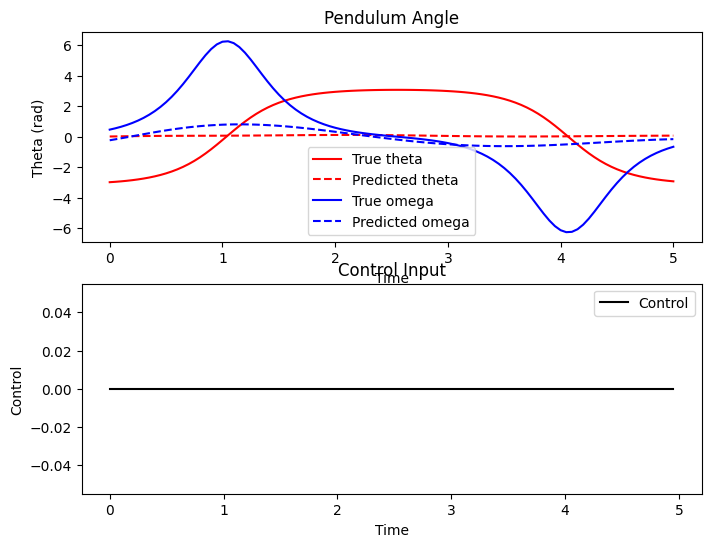

In [169]:
i = 3
test_xhist_np = test_xhist.cpu().numpy()
test_xhist_plt, test_uhist_plt, test_xhist_pred_plt = test_xhist_np[i, :],  test_uhist_np[i, :], test_xhist_pred_np[i, :]
test_xhist_pred_plt = np.clip(test_xhist_pred_plt, -10, 10)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
# ax[0].plot(eval_ts, angle_wrap(eval_xhist[:, 0], "-pi:pi"), color='red', label="True theta")
# ax[0].plot(eval_ts, angle_wrap(eval_xhist_pred[:, 0], "-pi:pi"), color='red', label="Predicted theta", linestyle='--')
ax[0].plot(ts, test_xhist_plt[:, 0], color='red', label="True theta")
ax[0].plot(ts, test_xhist_pred_plt[:, 0], color='red', label="Predicted theta", linestyle='--')
ax[0].plot(ts, test_xhist_plt[:, 1], color='blue', label="True omega")
ax[0].plot(ts, test_xhist_pred_plt[:, 1], color='blue', label="Predicted omega", linestyle='--')
ax[0].set_title("Pendulum Angle")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Theta (rad)")
ax[0].legend()

ax[1].plot(ts[:-1], test_uhist_plt[:, 0], color='black', label="Control")
ax[1].set_title("Control Input")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Control")
ax[1].legend()

